<a href="https://colab.research.google.com/github/agushery/TA/blob/main/PROGRAM_TUGAS_AKHIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Untuk Peramalan Mobilitas Masyarakat Kota Denpasar Dengan Metode LSTM (Long Short-Term Memory)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Persiapan Library

In [2]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns

## Insert Dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/TA/Data-Mobilitas.csv")

In [4]:
df.head()

,No,Tempat,9/1/2021,9/2/2021,9/3/2021,9/4/2021,9/5/2021,9/6/2021,9/7/2021,9/8/2021,9/9/2021,9/10/2021,9/11/2021,9/12/2021,9/13/2021,9/14/2021,9/15/2021,9/16/2021,9/17/2021,9/18/2021,9/19/2021,9/20/2021,9/21/2021,9/22/2021,9/23/2021,9/24/2021,9/25/2021,9/26/2021,9/27/2021,9/28/2021,9/29/2021,9/30/2021,10/1/2021,10/2/2021,10/3/2021,10/4/2021,10/5/2021,10/6/2021,10/7/2021,10/8/2021,10/9/2021,10/10/2021,10/11/2021,10/12/2021,10/13/2021,10/14/2021,10/15/2021,10/16/2021,10/17/2021,10/18/2021,10/19/2021,10/20/2021,10/21/2021,10/22/2021,10/23/2021,10/24/2021,10/25/2021,10/26/2021,10/27/2021,10/28/2021,10/29/2021,10/30/2021,10/31/2021
0,1.0,Banjar Mertanadhi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,94.0,0.0,0.0,5.0,0.0,1.0,3.0,12.0,16.0,35.0,2.0,1.0,29.0,10.0,9.0,136.0,120.0,279.0,217.0,19.0,130.0,102.0,105.0,67.0,97.0,94.0,55.0,127.0,116.0,110.0,118.0,173.0,119.0,41.0,121.0,39.0,35.0,140.0,109.0,65.0,41.0,133.0,128.0,83.0,89.0,87.0,55.0,28.0
2,3.0,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,Politeknik Nasional Denpasar (Polnas Denpasar),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing Data

In [5]:
df.shape

(147, 63)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 63 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   No          146 non-null    float64
 1   Tempat      146 non-null    object 
 2   9/1/2021    146 non-null    float64
 3   9/2/2021    146 non-null    float64
 4   9/3/2021    146 non-null    float64
 5   9/4/2021    146 non-null    float64
 6   9/5/2021    146 non-null    float64
 7   9/6/2021    146 non-null    float64
 8   9/7/2021    146 non-null    float64
 9   9/8/2021    146 non-null    float64
 10  9/9/2021    146 non-null    float64
 11  9/10/2021   146 non-null    float64
 12  9/11/2021   146 non-null    float64
 13  9/12/2021   146 non-null    float64
 14  9/13/2021   146 non-null    float64
 15  9/14/2021   146 non-null    float64
 16  9/15/2021   146 non-null    float64
 17  9/16/2021   146 non-null    float64
 18  9/17/2021   146 non-null    float64
 19  9/18/2021   146 non-null    f

In [7]:
df.drop('No', axis=1, inplace=True)
df.head()

,Tempat,9/1/2021,9/2/2021,9/3/2021,9/4/2021,9/5/2021,9/6/2021,9/7/2021,9/8/2021,9/9/2021,9/10/2021,9/11/2021,9/12/2021,9/13/2021,9/14/2021,9/15/2021,9/16/2021,9/17/2021,9/18/2021,9/19/2021,9/20/2021,9/21/2021,9/22/2021,9/23/2021,9/24/2021,9/25/2021,9/26/2021,9/27/2021,9/28/2021,9/29/2021,9/30/2021,10/1/2021,10/2/2021,10/3/2021,10/4/2021,10/5/2021,10/6/2021,10/7/2021,10/8/2021,10/9/2021,10/10/2021,10/11/2021,10/12/2021,10/13/2021,10/14/2021,10/15/2021,10/16/2021,10/17/2021,10/18/2021,10/19/2021,10/20/2021,10/21/2021,10/22/2021,10/23/2021,10/24/2021,10/25/2021,10/26/2021,10/27/2021,10/28/2021,10/29/2021,10/30/2021,10/31/2021
0,Banjar Mertanadhi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,94.0,0.0,0.0,5.0,0.0,1.0,3.0,12.0,16.0,35.0,2.0,1.0,29.0,10.0,9.0,136.0,120.0,279.0,217.0,19.0,130.0,102.0,105.0,67.0,97.0,94.0,55.0,127.0,116.0,110.0,118.0,173.0,119.0,41.0,121.0,39.0,35.0,140.0,109.0,65.0,41.0,133.0,128.0,83.0,89.0,87.0,55.0,28.0
2,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Politeknik Nasional Denpasar (Polnas Denpasar),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df = df.melt(id_vars=['Tempat'], var_name='Tanggal', value_name='Jumlah')
df.head()

,Tempat,Tanggal,Jumlah
0,Banjar Mertanadhi,9/1/2021,0.0
1,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,9/1/2021,0.0
2,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,9/1/2021,0.0
3,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,9/1/2021,0.0
4,Politeknik Nasional Denpasar (Polnas Denpasar),9/1/2021,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8967 entries, 0 to 8966
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tempat   8906 non-null   object 
 1   Tanggal  8967 non-null   object 
 2   Jumlah   8905 non-null   float64
dtypes: float64(1), object(2)
memory usage: 210.3+ KB


In [10]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])

In [11]:
df.isnull().sum()

Tempat     61
Tanggal     0
Jumlah     62
dtype: int64

In [12]:
df = df.dropna()
df.shape

(8905, 3)

In [13]:
df_total = df.groupby('Tempat')['Jumlah'].sum()
df_total = df_total.to_frame().reset_index()
df_total.head()

,Tempat,Jumlah
0,BPRS Fajar Sejahtera Bali,1.0
1,Bali Post,3.0
2,Banjar Alangkajeng Gede,3.0
3,Banjar Alangkajeng Menak,2.0
4,Banjar Busung Yeh Kangin,1.0


In [14]:
df_total.shape

(146, 2)

In [15]:
df_total.index = df_total['Tempat']
df_total = df_total.drop(['Tempat'], axis=1)

In [16]:
df_total.shape

(146, 1)

In [17]:
def topcase(tipe, warna):
    plt.axes(axisbelow=True)
    plt.barh(
        df_total.sort_values(tipe)[tipe].index[-10:],
        df_total.sort_values(tipe)[tipe].values[-10:],
        color=warna)
    plt.tick_params(size=5,labelsize = 13)
    plt.xlabel(tipe + " Mobilitas",fontsize=18)
    plt.title("10 Tempat Dengan Mobilitas Tinggi",fontsize=20)
    plt.grid()
    plt.show()

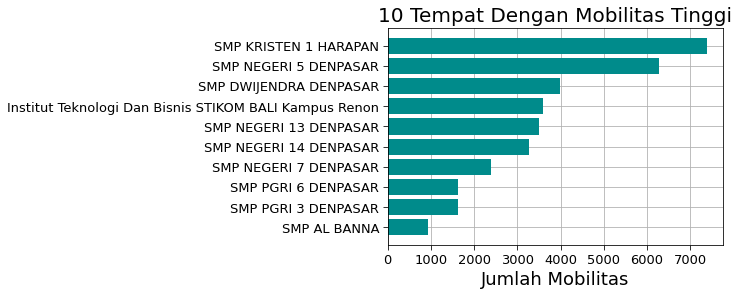

In [18]:
topcase('Jumlah','darkcyan')

In [19]:
df_final = df.groupby('Tanggal')['Jumlah'].sum()
df_final = df_final.to_frame().reset_index()
df_final.head()

,Tanggal,Jumlah
0,2021-09-01,0.0
1,2021-09-02,9.0
2,2021-09-03,9.0
3,2021-09-04,2.0
4,2021-09-05,17.0


In [20]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  61 non-null     datetime64[ns]
 1   Jumlah   61 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [21]:
df_final = df_final.set_index('Tanggal')
df_final['Jumlah'] = df_final['Jumlah'].astype(int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2021-09-01 to 2021-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Jumlah  61 non-null     int64
dtypes: int64(1)
memory usage: 976.0 bytes


In [22]:
df_final

,Jumlah
Tanggal,
2021-09-01,0
2021-09-02,9
2021-09-03,9
2021-09-04,2
2021-09-05,17
...,...
2021-10-27,2841
2021-10-28,2842
2021-10-29,2113


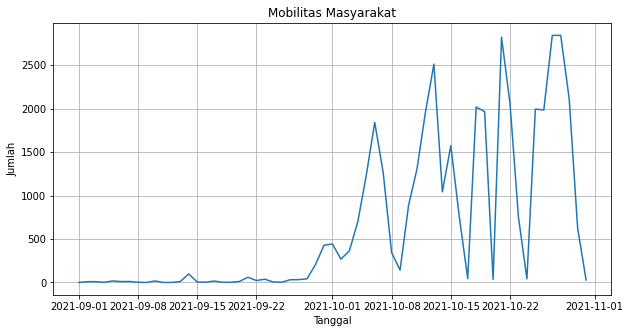

In [23]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Tanggal', y='Jumlah', data=df_final)
plt.title('Mobilitas Masyarakat')
plt.grid()
plt.show()

In [24]:
print("MAX : ", max(df_final['Jumlah']))
print("MIN : ", min(df_final['Jumlah']))

MAX :  2842
MIN :  0


In [25]:
df_final.head()

,Jumlah
Tanggal,
2021-09-01,0
2021-09-02,9
2021-09-03,9
2021-09-04,2
2021-09-05,17


In [26]:
df_final.tail()

,Jumlah
Tanggal,
2021-10-27,2841
2021-10-28,2842
2021-10-29,2113
2021-10-30,626
2021-10-31,28


In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_final['scaled'] = scaler.fit_transform(df_final)

In [28]:
df_final

,Jumlah,scaled
Tanggal,,
2021-09-01,0,0.000000
2021-09-02,9,0.003167
2021-09-03,9,0.003167
2021-09-04,2,0.000704
2021-09-05,17,0.005982
...,...,...
2021-10-27,2841,0.999648
2021-10-28,2842,1.000000
2021-10-29,2113,0.743490


In [29]:
ratio = 0.9
n = int(ratio * len(df_final))
train = df_final[:n]
test = df_final[n:]

print(train.shape)
print(test.shape)

(54, 2)
(7, 2)


In [30]:
def sliding_window(data, time_steps):
    sub_seq, next_values = [], []
    for i in range(len(data)-time_steps):
        sub_seq.append(data[i:i+time_steps])
        next_values.append(data[i+time_steps])
    X = np.stack(sub_seq)
    y = np.array(next_values)
    return X,y

In [31]:
time_steps = 5
X_train, y_train = sliding_window(train[['scaled']].values, time_steps)
X_test, y_test = sliding_window(df_final[len(df_final)-len(test)-time_steps:][['scaled']].values, time_steps)

In [32]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(49, 5, 1) (49, 1)
(7, 5, 1) (7, 1)


In [33]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [34]:
# define the grid search parameters
LSTM_unit = [32,64,128,256,512]
dropout = [0.1,0.2,0.3]
optimizer= ['RMSProp', 'SGD', 'Adam']

In [35]:
def create_model(LSTM_unit=0, dropout=0, optimizer=''):
  # create model
  model = Sequential()
  model.add(LSTM(units=LSTM_unit, return_sequences = True, input_shape=(time_steps, 1)))
  model.add(Dropout(dropout))
  model.add(LSTM(units=LSTM_unit, return_sequences = True))
  model.add(Dropout(dropout))
  model.add(LSTM(units=LSTM_unit))
  model.add(Dropout(dropout))
  model.add(Dense(1))
  # Compile model
  model.compile(loss = 'mse', optimizer = optimizer, metrics= root_mean_squared_error)
  #model.summary()
  return model

In [36]:
# Early Stopping
es = EarlyStopping(monitor = 'loss', mode = "min", patience = 20)

In [37]:
# Hypertunning  
model = KerasRegressor(build_fn=create_model, epochs=500, batch_size=1, callbacks=[es])
param = dict(LSTM_unit=LSTM_unit, dropout=dropout, optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param, n_jobs=-1, cv=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [38]:
# training
grid_result = grid.fit(X_train, y_train)

Epoch 1/500
49/49 [==============================] - 6s 20ms/step - loss: 0.1004 - root_mean_squared_error: 0.2086
Epoch 2/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0814 - root_mean_squared_error: 0.1957
Epoch 3/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0764 - root_mean_squared_error: 0.1843
Epoch 4/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0662 - root_mean_squared_error: 0.1799
Epoch 5/500
49/49 [==============================] - 1s 20ms/step - loss: 0.1025 - root_mean_squared_error: 0.1977
Epoch 6/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0618 - root_mean_squared_error: 0.1686
Epoch 7/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0706 - root_mean_squared_error: 0.1762
Epoch 8/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0719 - root_mean_squared_error: 0.1816
Epoch 9/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0554

In [39]:
# results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.112329 using {'LSTM_unit': 512, 'dropout': 0.1, 'optimizer': 'RMSProp'}
-0.179717 (0.046507) with: {'LSTM_unit': 32, 'dropout': 0.1, 'optimizer': 'RMSProp'}
-0.177681 (0.041728) with: {'LSTM_unit': 32, 'dropout': 0.1, 'optimizer': 'SGD'}
-0.179579 (0.039999) with: {'LSTM_unit': 32, 'dropout': 0.1, 'optimizer': 'Adam'}
-0.177556 (0.048357) with: {'LSTM_unit': 32, 'dropout': 0.2, 'optimizer': 'RMSProp'}
-0.170667 (0.051212) with: {'LSTM_unit': 32, 'dropout': 0.2, 'optimizer': 'SGD'}
-0.172633 (0.049111) with: {'LSTM_unit': 32, 'dropout': 0.2, 'optimizer': 'Adam'}
-0.166442 (0.049359) with: {'LSTM_unit': 32, 'dropout': 0.3, 'optimizer': 'RMSProp'}
-0.184961 (0.041578) with: {'LSTM_unit': 32, 'dropout': 0.3, 'optimizer': 'SGD'}
-0.181760 (0.034247) with: {'LSTM_unit': 32, 'dropout': 0.3, 'optimizer': 'Adam'}
-0.174070 (0.045463) with: {'LSTM_unit': 64, 'dropout': 0.1, 'optimizer': 'RMSProp'}
-0.183141 (0.040835) with: {'LSTM_unit': 64, 'dropout': 0.1, 'optimizer': 'SGD'}
-0.167706

In [40]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 512)            1052672   
                                                                 
 dropout (Dropout)           (None, 5, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 512)            2099200   
                                                                 
 dropout_1 (Dropout)         (None, 5, 512)            0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [41]:
history = best_model.history

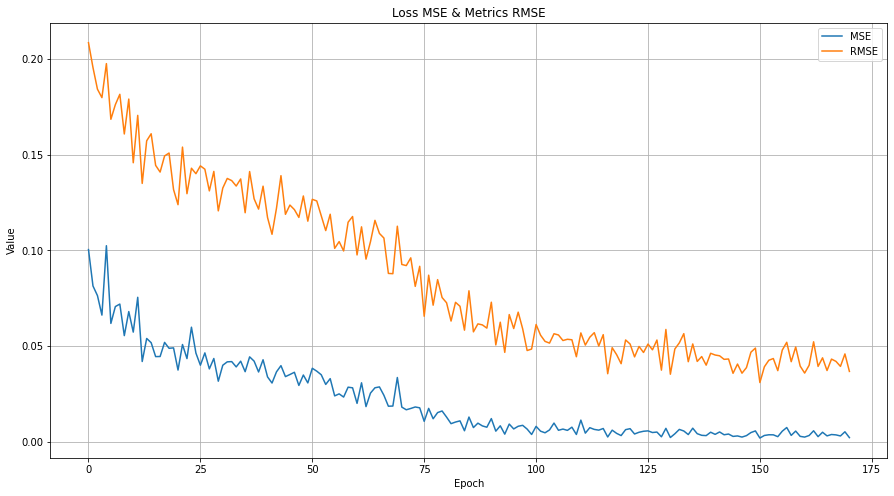

In [42]:
# grafik loss function MSE
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Loss MSE & Metrics RMSE')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [43]:
test['Prediksi'] = scaler.inverse_transform(best_model.predict(X_test))
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Jumlah,scaled,Prediksi
Tanggal,,,
2021-10-25,1993,0.701267,627.521240
2021-10-26,1984,0.698100,1088.818604
2021-10-27,2841,0.999648,353.108948
2021-10-28,2842,1.000000,2922.793945
2021-10-29,2113,0.743490,816.718994
2021-10-30,626,0.220267,2397.225586
2021-10-31,28,0.009852,1790.972046


In [44]:
rmse = np.sqrt(mean_squared_error(test['Jumlah'], test['Prediksi']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1548.625


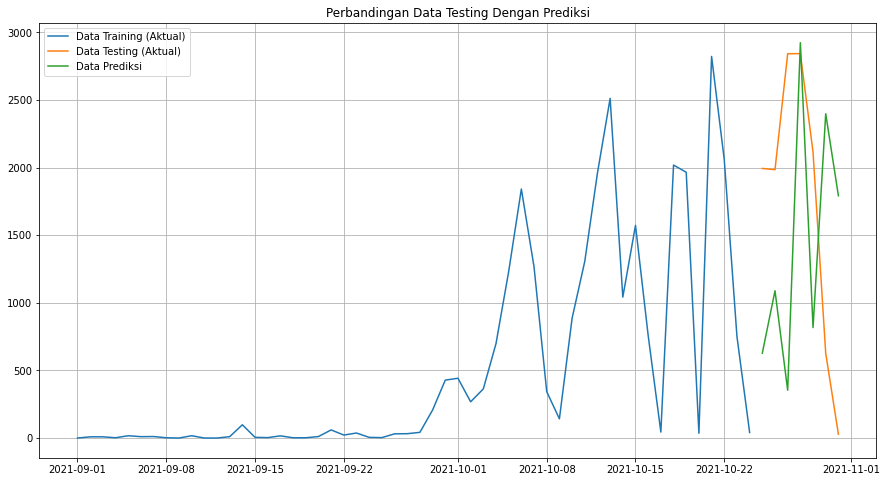

In [45]:
plt.figure(figsize=(15,8))
plt.grid()
plt.title("Perbandingan Data Testing Dengan Prediksi")
plt.plot(train['Jumlah'], label="Data Training (Aktual)")
plt.plot(test['Jumlah'], label="Data Testing (Aktual)")
plt.plot(test['Prediksi'], label="Data Prediksi")
plt.legend(loc="upper left")
plt.show()

In [46]:
pred_list = []
batch = test[-time_steps:][['scaled']].values.reshape((1, time_steps, 1))
prediksi = 7
for i in range(prediksi):   
    pred_list.append(best_model.predict(batch)[0])
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [47]:
add_dates = [df_final.index[-1] + DateOffset(days=x) for x in range(0,prediksi+1) ]
df_prediksi = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=add_dates[1:],
                          columns=['Prediksi'])
df_prediksi

,Prediksi
2021-11-01,1920.253033
2021-11-02,1171.861091
2021-11-03,542.538472
2021-11-04,3416.663398
2021-11-05,1941.228034
2021-11-06,479.809375
2021-11-07,2337.231590


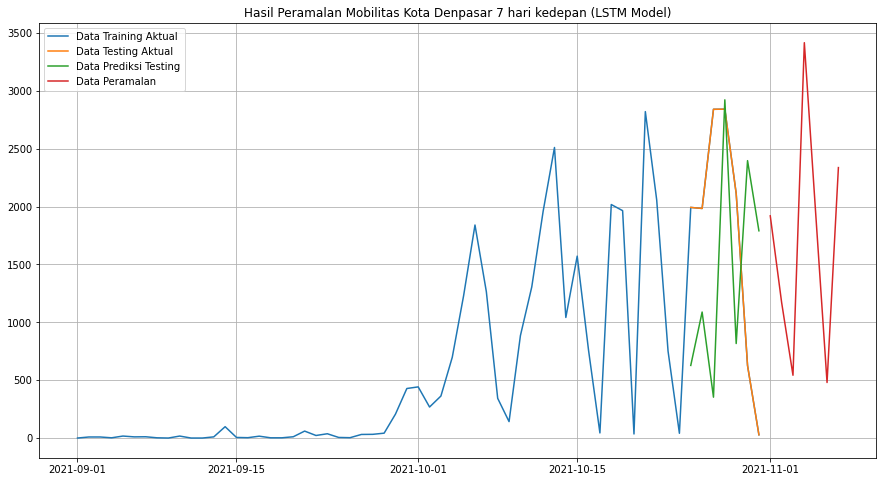

In [48]:
plt.figure(figsize=(15,8))
plt.grid()
plt.title("Hasil Peramalan Mobilitas Kota Denpasar 7 hari kedepan (LSTM Model)")
plt.plot(df_final['Jumlah'], label="Data Training Aktual")
plt.plot(test['Jumlah'], label="Data Testing Aktual")
plt.plot(test['Prediksi'], label="Data Prediksi Testing")
plt.plot(df_prediksi['Prediksi'], label="Data Peramalan")
plt.legend(loc="upper left")

In [49]:
best_model.save('best_model.h5')

In [50]:
std = pd.DataFrame(stds)
std.to_excel('std.xlsx')

In [51]:
means = pd.DataFrame(means)
means.to_excel('means.xlsx')

In [52]:
test.to_excel('test.xlsx')
train.to_excel('train.xlsx')

In [53]:
df_prediksi.to_excel('hasil-peramalan.xlsx')